# IMDB 
adapted from FastAI Library https://github.com/fastai/course-v3/tree/master/nbs/dl1

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
#os.environ["CUDA_VISIBLE_DEVICES"] = "3"
print('CUDA available: {}  Using device {}'.format(torch.cuda.is_available(), os.environ['CUDA_VISIBLE_DEVICES']))

CUDA available: True  Using device 0


## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb_sample/small_texts.csv'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb_sample/texts.csv')]

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path/'texts.csv')
df.head() 

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [5]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [6]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [7]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [8]:
data = load_data(path)

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [9]:
data = TextClasDataBunch.from_csv(path, 'texts.csv',)

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids to tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [10]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

In [11]:
print("Dictionary size")
print(len(data.vocab.itos))

Dictionary size
9024


In [12]:
df.head(1)

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False


And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [13]:
data.train_ds[0][0]

Text xxbos xxmaj after xxunk myself on a variety of seemingly immature movies xxunk on ex - rental dvds , i figured that the time was right for a little serious drama and who better to provide it than xxmaj sam xxmaj mendes ? xxmaj for a number of reasons , " xxmaj american xxmaj beauty " does n't appeal to me as much as this film which is easily the xxunk thing that xxmaj tom xxmaj hanks has ever done and probably one of the most underrated films of the last decade . xxmaj for this is not a simple gangster tale lifted from its graphic novel origins , and is simply wonderful to watch because of it . xxmaj and despite my usual xxunk to any film with xxmaj tom xxmaj hanks ' name on it ( still ca n't watch " xxmaj big " without wanting a cat to kick ) , i 'm glad i gave this a try because this is one of those movies that you 'll kick yourself for if you miss it . 
 
  xxmaj normally squeaky - clean xxmaj hanks plays xxmaj michael xxmaj sullivan , a devoted family man and father of two son

But the underlying data is all numbers

In [14]:
data.train_ds[0][0].data[:10]

array([   2,    5,  123,    0,  615,   36,   13, 1878,   14, 1604])

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [15]:
data = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0)
                .databunch())

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [16]:
bs=48

Now let's grab the full dataset for what follows.

In [17]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/tmp_clas'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/README'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/train'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/models'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/tmp_lm'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/test'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/unsup')]

In [18]:
(path/'train').ls()

[PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/train/pos'),
 PosixPath('/gpfs/home/s4s004/vanstee/.fastai/data/imdb/train/neg')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [19]:
#(path/'data_lm.pkl').is_file()

In [20]:
# Only run if pkl file doesnt exist
if((path/'data_lm.pkl').is_file()==False) :
    data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
    data_lm.save('data_lm.pkl')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [21]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)

In [22]:
data_lm.show_batch()

idx,text
0,", my wartime - xxmaj glasgow - raised mother would love this , should i ever find a copy of it ...."
1,xxmaj aris xxmaj iliopulos finally got the chutzpah to film a script that xxmaj wood saved from ...
2,all unfold . \n \n xxup note : i just watched this a second time and really hope they explore w...
3,"no blood , nothing . xxmaj yet xxmaj alison fled the building and collapsed in the street , cove..."
4,xxmaj dr. xxmaj melfi concludes that xxmaj tony 's problems actually derive from his mother xxma...


We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

### Instantiate Learner and run learning rate finder

In [23]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [24]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


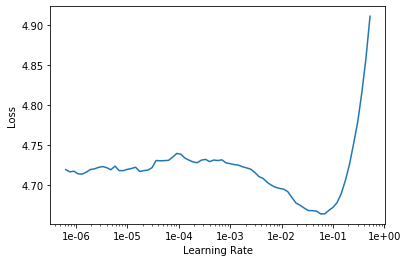

In [25]:
learn.recorder.plot(skip_end=15)

### Fit One Cycle for last layer

In [26]:
# This is the fit one cycle step to build the tuned language model.... already run and saved to save time.
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.161972,4.017143,0.296423,21:12


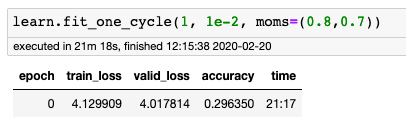

In [27]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [28]:
learn.unfreeze()

### Fit one cycle for all layers

In [29]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))
learn.save('fine_tuned')

epoch,train_loss,valid_loss,accuracy,time
0,3.852792,3.808983,0.318384,23:55
1,3.836388,3.767186,0.325573,23:56
2,3.761253,3.737510,0.330115,23:56
3,3.724102,3.701380,0.334485,23:56
4,3.668366,3.668862,0.338214,23:59
5,3.613127,3.644998,0.340998,23:57
6,3.507204,3.626655,0.343157,23:55
7,3.450477,3.614653,0.345021,23:56
8,3.416573,3.612333,0.345704,23:56
9,3.351133,3.613603,0.345587,23:57


### Test the Fine Tuned Language Model

How good is our model? Well let's try to see what it predicts after a few given words.

In [30]:
learn.load('fine_tuned');

In [31]:
TEXT = "I didnt like this movie because"
N_WORDS = 40
N_SENTENCES = 2

In [32]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I didnt like this movie because it was boring with stories that really did n't exist . Movies like Maybe a Day at the Church ( which was funny and funny because i think it was the funniest movie i 've ever
I didnt like this movie because it was so bad . The bad acting , the bad English accents and the bad special effects . All in all it was just , bad , bad . The main character was a poor


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [33]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [34]:
path = untar_data(URLs.IMDB)

In [35]:
# Only run if pkl file doesnt exist
if((path/'data_clas.pkl').is_file()==False) :
    data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
                 #grab all the text files in path
                 .split_by_folder(valid='test')
                 #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
                 .label_from_folder(classes=['neg', 'pos'])
                 #label them all with their folders
                 .databunch(bs=bs))

    data_clas.save('data_clas.pkl')

### Load Data

In [36]:
data_clas = load_data(path, 'data_clas.pkl', bs=bs)

In [37]:
data_clas.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxm...,pos
"xxbos * * xxmaj attention xxmaj spoilers * * \n \n xxmaj first of all , let me say that xxmaj r...",pos
xxbos xxmaj titanic directed by xxmaj james xxmaj cameron presents a fictional love story on the...,pos
xxbos xxmaj some have praised _ xxunk _ as a xxmaj disney adventure for adults . i do n't think ...,neg
xxbos xxup myra xxup breckinridge is one of those rare films that established its place in film ...,neg


We can then create a model to classify those reviews and load the encoder we saved before.

### Instantiate Learner and run lr find

In [38]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
_ = learn.load_encoder('fine_tuned_enc')
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [61, 400]            0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
RNNDropout           [61, 1152]           0          False     
______________________________________________________________________
BatchNorm1d          [1200]               2,400      True      
______________________________________________________________________
Dropout              [1200]               0          False     
______________________________________________________________________
Linear               [50]                 60,050     True      
______________________________________________________________________
ReLU                 [50]                 0          False     
________________________________________________

In [39]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


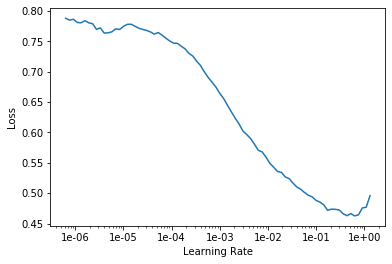

In [40]:
learn.recorder.plot()

### Fit One Cycle for last layer

epoch,train_loss,valid_loss,accuracy,time
0,0.254795,0.178537,0.933680,02:34


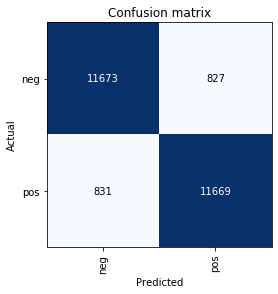

In [41]:
# (around 3 mins to run)
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
a=learn.interpret()
a.plot_confusion_matrix()

In [42]:
learn.save('first')
learn.load('first');

### Fit One Cycle last 2 layers

epoch,train_loss,valid_loss,accuracy,time
0,0.224306,0.158978,0.940960,02:49


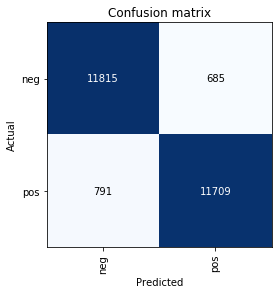

In [43]:
# (around 3 mins to run)
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
a=learn.interpret()
a.plot_confusion_matrix()

In [44]:
learn.save('second')
learn.load('second');

### Optional do fit one cycle on last 3 layers... one more time

epoch,train_loss,valid_loss,accuracy,time
0,0.202025,0.145779,0.946000,03:47


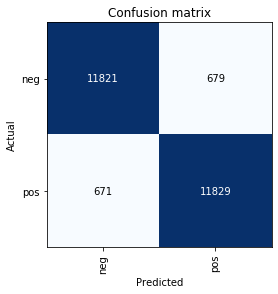

In [45]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
a=learn.interpret()
a.plot_confusion_matrix()

In [46]:
learn.save('third')
learn.load('third'); 

### Unfreeze all layers and train

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.195342,0.141543,0.948960,04:39
1,0.144833,0.141845,0.949160,05:07


## Experiment with your Model

In [48]:
learn.predict("I really loved that movie, it was awesome!")

(Category pos, tensor(1), tensor([4.7650e-05, 9.9995e-01]))

In [49]:
learn.predict("I really thought the movie was just fine!")

(Category pos, tensor(1), tensor([0.4834, 0.5166]))

In [50]:
learn.predict("ford vs ferrari was the epic movie of our time.  it was so cool, but there were parts that didnt make sense")

(Category pos, tensor(1), tensor([0.0460, 0.9540]))

In [51]:
learn.predict("i liked it in the beginning but was really bored by the end")

(Category neg, tensor(0), tensor([0.9746, 0.0254]))

In [52]:
learn.predict("the money i spent on the movie is not worth it")

(Category neg, tensor(0), tensor([0.9837, 0.0163]))

In [53]:
learn.predict("this movie was good and i recommend it")

(Category pos, tensor(1), tensor([3.9834e-04, 9.9960e-01]))

In [54]:
# learn.model

## Next Steps

Congratulations, you have trained your sentiment classifier to classify IMDB reviews automatically.  The above pattern is based on the ULMFit algorithm from Jeremy Howard.  https://arxiv.org/abs/1801.06146.  You can build many NLP classifiers using this technique and apply to many domains.   If you wanted to deploy this model, you could build a flask app with the fast ai dependencies and try to get that up and running!